# Verkaufsprognose to Excels (vp2xlsx)

Für die Verkaufsprognose sollen automatisch Excels für die Verkaufsberater generiert werden. Dies soll in ``Python`` geschehen mit Hilfe des Moduls ``xlsxwriter``.

## Load general modules

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [3]:
import pandas as pd
import numpy as np
import xlsxwriter as xlsx
from datetime import datetime, date 
from pa_lib.file import load_csv
from pa_lib.const import PA_DATA_DIR
PA_DATA_DIR

WindowsPath('C:/Users/kpf/data')

## Load Data

Input files:

- ``EK_LIST_KOMPLETT.csv``: Current deployment file with all computed leads.
- ``vkber_data.csv``:       The new VB list, needs to be updated as well every 2 weeks before deployment.

In [177]:
ek_list = load_csv('EK_LIST_2W_KOMPLETT.csv',sep=';', encoding='ANSI' )

2019-07-16 11:57:10 [INFO] Reading from file C:\Users\stc\data\EK_LIST_2W_KOMPLETT.csv
2019-07-16 11:57:10 [INFO] Finished loading CSV in 0.12s (0.14s CPU)


In [182]:
gv_VB_KUERZ_new_raw             = load_csv('vkber_data.csv',sep=',', encoding='UTF-8' )
gv_VB_KUERZ_new_raw['Vorname']  = [x.split(' ')[-1]            for x     in gv_VB_KUERZ_new_raw['KOMBI_NAME']]
gv_VB_KUERZ_new_raw['Nachname'] = [' '.join(x.split(' ')[:-1]) for x     in gv_VB_KUERZ_new_raw['KOMBI_NAME']]

vkber_list = gv_VB_KUERZ_new_raw.loc[:,["Vorname", "Nachname", "E_MAIL", "FUNKTION", "KURZZEICHEN"]].set_index("KURZZEICHEN")

2019-07-16 12:01:54 [INFO] Reading from file C:\Users\stc\data\vkber_data.csv
2019-07-16 12:01:54 [INFO] Finished loading CSV in 0.0s (0.0s CPU)


In [185]:
vkber_list.head(5)

,Vorname,Nachname,E_MAIL,FUNKTION
KURZZEICHEN,,,,
ABS,Bernhard,Schnyder,bernhard.schnyder@apgsga.ch,Key Account Management
ACO,Alma,Coralic,alma.coralic@apgsga.ch,Verkaufsberatung Südost Aussendienst
AST,Andreas,Steltzlen,andreas.steltzlen@apgsga.ch,Leitung Verkaufsberatung Bern Mitte
BAM,Marcel,Baumann,marcel.baumann@apgsga.ch,Leitung KAM Cross Solutions
BBO,Barbara,Borri,barbara.borri@apgsga.ch,Key Account Management


In [31]:
"""
gv_VB_KUERZ = {"ACO":["ACO"], "OSS":["OSS"], "RIN":["RIN"], 
               "FCO":["FCO", "LPA", "TRA"], 
               "YAM":["YAM", "ANS"],
               "ADA":["ADA", "LPA", "TRA"],
               "CKT":["CKT"], "LPA":["LPA"], "JAN":["JAN"],
               "JCO":["JCO"], "RFO":["RFO"], "RPO":["RPO", "ROF"],
               "RUC":["RUC"], "TRA":["TRA"], "REM":["REM"],
               "AST":["AST"]} ## Mapping für die einzelnen Top 20 Excel Listen pro VB
"""
gv_VB_KUERZ = {x: [y] for (x,y) in zip(gv_VB_KUERZ_new_raw['KURZZEICHEN'],gv_VB_KUERZ_new_raw['KURZZEICHEN'])}

## Spaltenauswahl & DType-Bereinigung

In [32]:
ek_list_ultrakompakt = (ek_list.loc[(pd.isna(ek_list.Kleinkunde) & 
                                     pd.isna(ek_list.Neukunde) & 
                                     pd.isna(ek_list.Insolvenz) & 
                                     pd.isna(ek_list.Umsatz_erreicht) & 
                                     pd.isna(ek_list.kuerzlich_gebucht) & 
                                     pd.isna(ek_list.kuerzlich_im_aushang) & 
                                     pd.isna(ek_list.kuerzlich_im_kontakt) & 
                                     pd.isna(ek_list.VB_FILTER_AKTIV)), ## Zeilen-Bedinungen
                                     "ENDKUNDE_NR Endkunde HB_APG Agentur HB_Agentur PLZ Ort".split() + 
                                     [col for col in ek_list.columns if 'Net_2'in col] +
                                     "letzte_VBs letzter_Kontakt KZ_letzter_Ktkt Kanal Betreff letzte_Kamp_erfasst letzte_Kamp_Beginn Verkaufsgebiet VB_VK_Geb".split()+
                                     [col for col in ek_list.columns if 'prob_KW' in col]]) ## Spalten-Auswahl


In [171]:
ek_list_ultrakompakt["PLZ"]                 = ek_list_ultrakompakt["PLZ"].fillna(0).astype(np.int64)
ek_list_ultrakompakt["ENDKUNDE_NR"]         = ek_list_ultrakompakt["ENDKUNDE_NR"].fillna(0).astype(np.int64) # Zur schoeneren Darstellung im Excel

for x in ek_list_ultrakompakt.keys():
    if 'Net_' in x:
        ek_list_ultrakompakt[x] = ek_list_ultrakompakt[x].fillna(0).astype(np.int64)

ek_list_ultrakompakt['letzter_Kontakt']     = pd.to_datetime(ek_list_ultrakompakt['letzter_Kontakt'],     format='%Y-%m-%d')
ek_list_ultrakompakt['letzte_Kamp_erfasst'] = pd.to_datetime(ek_list_ultrakompakt['letzte_Kamp_erfasst'], format='%Y-%m-%d')
ek_list_ultrakompakt['letzte_Kamp_Beginn']  = pd.to_datetime(ek_list_ultrakompakt['letzte_Kamp_Beginn'],  format='%Y-%m-%d')

## Zuteilung und die einzelnen VBs


In [172]:
ek_list_vb_dict = {}
for x in gv_VB_KUERZ.keys():
    ek_list_vb_dict[x] = (ek_list_ultrakompakt[ek_list_ultrakompakt.HB_APG.isin(gv_VB_KUERZ[x]) |             # VB Endkunde
                                               ek_list_ultrakompakt.HB_Agentur.isin(gv_VB_KUERZ[x])]          # VB Agentur
                         .sort_values([col for col in ek_list.columns if 'prob_KW' in col], ascending=False)) # highest probability first.

In [173]:
dict_vb_num_leads = {x : ek_list_vb_dict[x].shape[0] for x in ek_list_vb_dict.keys()}
test_dict = pd.DataFrame.from_dict(dict_vb_num_leads, 
                                   orient= 'index',
                                   columns=['total_leads'])
test_dict.head(4)

,total_leads
ABS,27
ACO,172
AST,0
BAM,97


In [186]:
vkber_list = vkber_list.merge(test_dict, left_index=True, right_index=True)

In [190]:
vkber_list.head(5)#sort_values("total_leads", ascending= False)

,Vorname,Nachname,E_MAIL,FUNKTION,total_leads
KURZZEICHEN,,,,,
ABS,Bernhard,Schnyder,bernhard.schnyder@apgsga.ch,Key Account Management,27
ACO,Alma,Coralic,alma.coralic@apgsga.ch,Verkaufsberatung Südost Aussendienst,172
AST,Andreas,Steltzlen,andreas.steltzlen@apgsga.ch,Leitung Verkaufsberatung Bern Mitte,0
BAM,Marcel,Baumann,marcel.baumann@apgsga.ch,Leitung KAM Cross Solutions,97
BBO,Barbara,Borri,barbara.borri@apgsga.ch,Key Account Management,0


In [199]:
del write_xlsx
from pa_lib.file import write_xlsx

In [200]:
write_xlsx(vkber_list, "temp01.xlsx", sheet_name='VK')

## XlsxWriter

### Spezielle Spaltennamen und Info-Texte im Excel (definiert durch JLU)

In [125]:
dict_xlsx_col_names = dict(zip(ek_list_ultrakompakt.keys(),ek_list_ultrakompakt.keys())) # map all names on itself, then adjust those which need to be adjusted:
dict_xlsx_col_names['ENDKUNDE_NR']         = 'Gepard-Nr. Endkunde'
dict_xlsx_col_names['HB_APG']              = 'VB Endkunde'
dict_xlsx_col_names['HB_Agentur']          = 'VB Agentur'
dict_xlsx_col_names['letzte_VBs']          = 'VBs letzte Kampagnen'
dict_xlsx_col_names['letzter_Kontakt']     = 'Letzter CRM-Kontakt'
dict_xlsx_col_names['KZ_letzter_Ktkt']     = 'Kz letzter Kontakt'
dict_xlsx_col_names['letzte_Kamp_erfasst'] = 'Letzte Kampagne erfasst am'
dict_xlsx_col_names['letzte_Kamp_Beginn']  = 'Beginn letzte Kampagne'
dict_xlsx_col_names['VB_VK_Geb']           = 'Gebiets-VB'
for x in dict_jlu.keys():
    if 'prob_' in x:
        dict_xlsx_col_names[x]           = 'Chance'

In [57]:
info_text = """Liste von potenziell interessanten Kundenkontakten.
Die Liste wird alle 2 Wochen bereitgestellt.\n
Bitte in den letzten 2 Spalten Feedback eintragen, auch Vorschläge für die Verbesserung der Liste sind willkommen. Vielen Dank."""

AxesSubplot(0.125,0.125;0.775x0.755)


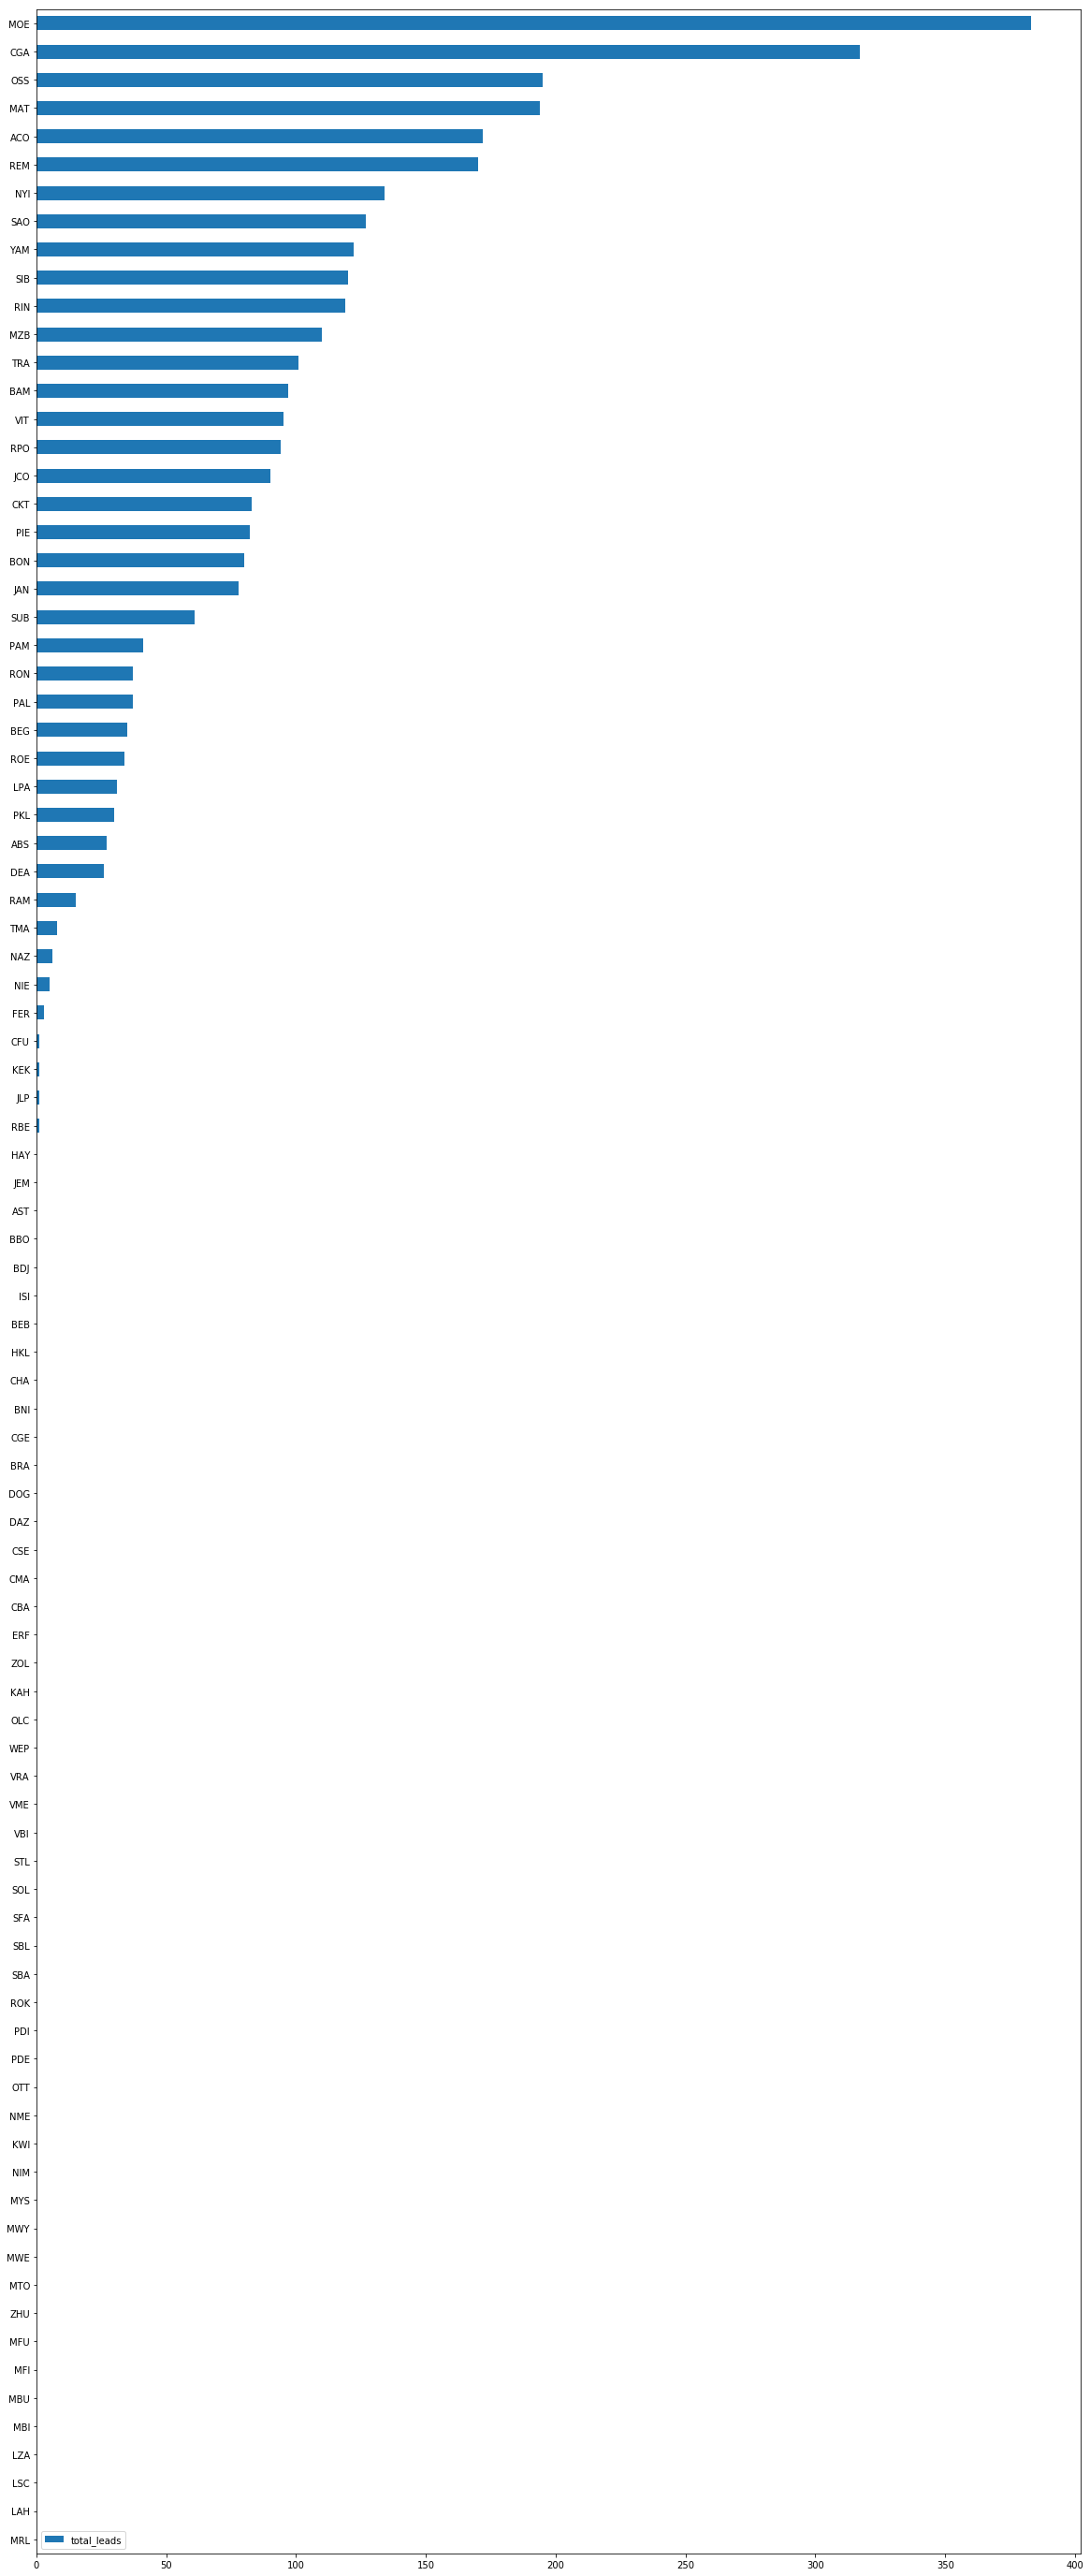

In [106]:
print(test_dict.sort_values("total_leads").plot.barh(figsize=(20,50)))

[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023E81A7A710>]]


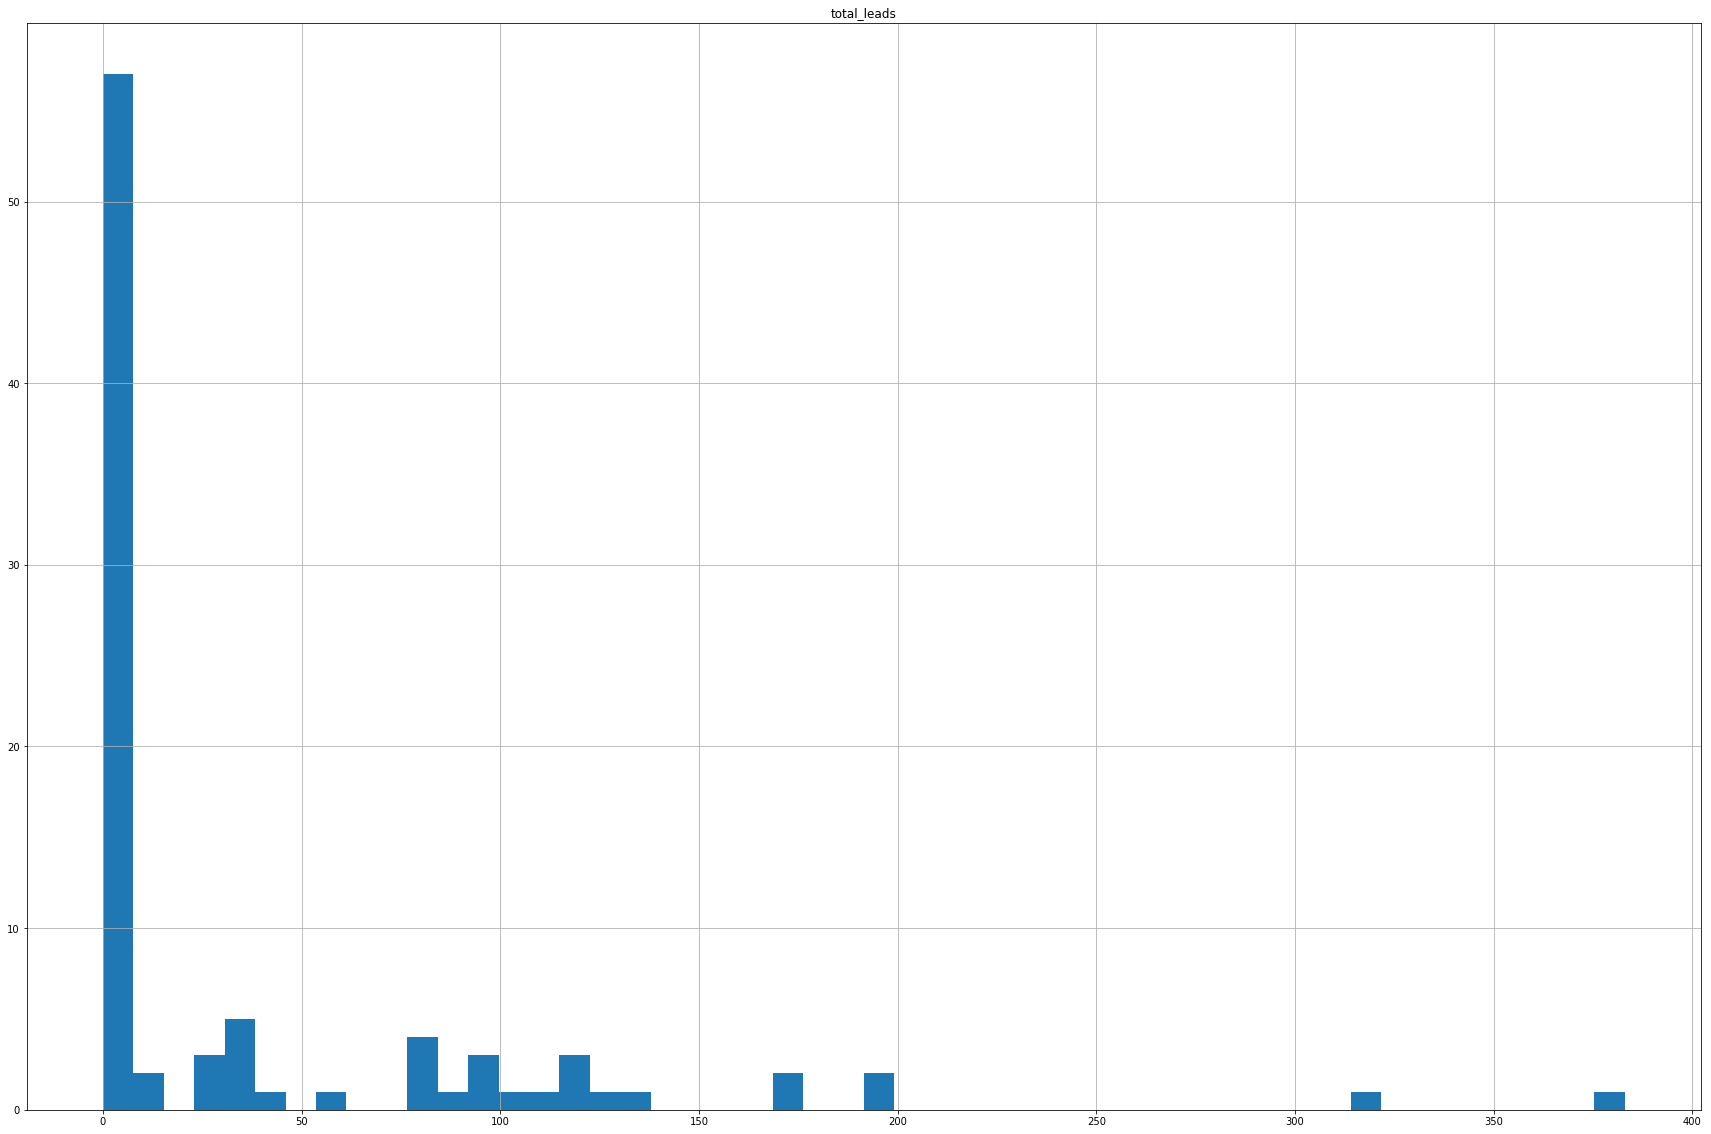

In [118]:
print(test_dict.hist(figsize=(30,20), bins=50))

In [89]:
#help(test_dict.plot.bar)

In [128]:
def make_excel(dict_vb_df,gv_VB_TOP_N=20):
    """
    Input: Dictionary mit VBs als Keys und Dataframes (Top20 pro VB) als value.
    Output: Pro VB wird ein formartiertes Excel generiert.
    """
    file_name_templ = 'EK_LIST_2W_KOMPAKT_{0}'
    global no_leads
    no_leads = []  # This will be filled with VBs without leads.
    for vb in dict_vb_df.keys():
        if len(dict_vb_df[vb]) == 0:
            #print('Verkaufsberater '+ vb +' hat keine Leads.')
            no_leads += [vb]
            continue
        
        ## Technical Definitions:
        df_vb        = dict_vb_df[vb].head(gv_VB_TOP_N)
        column_names = df_vb.keys()                                                             # Column names, titles
        alphabet     = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'                                             # Alphabet
        W            = alphabet[len(column_names)]                                              # Feedback-Spalte, sollte Spalte W sein
        X            = alphabet[len(column_names)+1]                                            # Kommentar-Spalte, sollte Spalte X sein
        lengths      = list(np.vectorize(len)(df_vb.values.astype(str)).max(axis=0))            # Maximal character length for each column
        types        = dict(df_vb.dtypes.astype(str))                                           # Types for each column
        #excel_dict    = {letter: column  for (letter, column) in zip(letters, columns)}
        excel_dict   = {alphabet[i]: column_names[i] for i in range(0, len(column_names))}      # Dictionary: Column to Name
        excel_width  = {alphabet[i]: lengths[i]+1    for i in range(0, len(column_names))}      # Dictionary: Column to Widths
        #dict(ek_list_vb_dict["ACO"].astype('str').apply(lambda s: max(s.str.len())))
        
        ## Define feedback list for Drop-Down:
        feedback = {'validate': 'list',
                      'source': ['hilfreich', 'nicht hilfreich', 'nicht bearbeitet'],
                 'input_title': 'Bitte beurteilen:',
               'input_message': '- hilfreich\n- nicht hilfreich\n- nicht bearbeitet',
                 'error_title': 'Eingabe ungültig',
               'error_message': 'Bitte auswählen:\n  - hilfreich\n  - nicht hilfreich\n  - nicht bearbeitet'}

        ## Create a Pandas Excel writer using XlsxWriter as the engine:
        writer = pd.ExcelWriter(file_name_templ.format(vb)+'.xlsx', engine='xlsxwriter', datetime_format="dd.mm.yyyy")

        ## Convert the dataframe to an XlsxWriter Excel object:
        df_vb.to_excel(writer, sheet_name=file_name_templ.format(vb), index=False, freeze_panes=(1,5)) #, header=True)

        ## Create xlsxwriter workbook object:
        workbook  = writer.book
        worksheet = writer.sheets[file_name_templ.format(vb)]
        
        ## Define column formats:
        column_format_text     = workbook.add_format({'align': 'left',   'valign': 'bottom'})
        column_format_txt_wrap = workbook.add_format({'align': 'left',   'valign': 'bottom', 'text_wrap': True})     # Commentary fields need
        column_format_umsatz   = workbook.add_format({'align': 'right',  'valign': 'bottom', 'num_format': "#,###"}) # Netto-Umsatz!
        column_format_prob     = workbook.add_format({'align': 'right',  'valign': 'bottom', 'num_format': "#.0"})   # Probability
        column_format_integer  = workbook.add_format({'align': 'right',  'valign': 'bottom', 'num_format': "#"})     # Integers for PLZ and Gepard-Nr
        column_format_right    = workbook.add_format({'align': 'right',  'valign': 'bottom'}) # 
        column_format_left     = workbook.add_format({'align': 'left',   'valign': 'bottom'}) # 
        column_format_dropdown = workbook.add_format({'align': 'left',   'valign': 'bottom', 'bg_color': '#EAEAEA'})
        column_format_error    = workbook.add_format({'bg_color': 'black'})

        ## Define templates for special cell formats:
        cell_color_yellow      = workbook.add_format({'align': 'center', 'valign': 'bottom', 'bg_color': '#ffff00', 'bold': True,  'text_wrap' : True, 'rotation': 90})
        cell_color_blue        = workbook.add_format({'align': 'right',  'valign': 'bottom', 'bg_color': '#bdd7ee', 'bold': False, 'text_wrap' : True})
        cell_color_rotate      = workbook.add_format({'align': 'center', 'valign': 'bottom', 'bg_color': '#EAEAEA', 'bold': True,  'text_wrap' : True, 'rotation': 90})
        cell_color_norot       = workbook.add_format({'align': 'left',   'valign': 'bottom', 'bg_color': '#EAEAEA', 'bold': True,  'text_wrap' : True})

        ## Automised Setting/formating columns and top-row cells:
        for i in excel_dict.keys():
            # Write Columns:
            if types[excel_dict[i]] == 'float64':
                worksheet.set_column(i+':'+i, 5, column_format_prob) # Fixed length! Net values. 
            elif types[excel_dict[i]] == 'int64':
                if "Net_" in excel_dict[i]:
                    worksheet.set_column(i+':'+i, excel_width[i]+1, column_format_umsatz)
                else:
                    worksheet.set_column(i+':'+i, excel_width[i], column_format_integer) # Should only effect PLZ and Gepard-Nr.
            elif types[excel_dict[i]] == 'datetime64[ns]':
                worksheet.set_column(i+':'+i, 10, column_format_text) # Fixed length!
            elif types[excel_dict[i]] == 'object':
                if "Betreff" in excel_dict[i]:
                    worksheet.set_column(i+':'+i, 40, column_format_text) # Fixed length, Betreff contains comments on last contact with customer. can be long
                else:
                    worksheet.set_column(i+':'+i, excel_width[i], column_format_text)
            else:
                worksheet.set_column(i+':'+i, excel_width[i], column_format_error) # If this gets triggered, these cells are turned black
            
            
            # Write Top-row cells:
            if excel_width[i] - 10 < len(dict_jlu[excel_dict[i]]):
                worksheet.write(i+'1',  dict_xlsx_col_names[excel_dict[i]], cell_color_rotate)
            else:
                worksheet.write(i+'1',  dict_xlsx_col_names[excel_dict[i]], cell_color_norot)

        ## Manual Setting/formating columns and top-row cells:
        
        #Info-text box, should be vsible under the list on the left side:
        worksheet.insert_textbox('B'+str(gv_VB_TOP_N+2+1),
                                 info_text,
                                 {'width': 480, 'height': 100, 'fill': {'color': '#ddd9c3'}, 'line': {'width': 3.25}})

        #Feedback-column, W:
        worksheet.set_column(W +':'+ W, 15, column_format_left)
        worksheet.write(W+'1',  'Feedback - bitte auswählen', cell_color_yellow)
        for i in range(2,gv_VB_TOP_N+2):
            worksheet.write(W + str(i),'', column_format_dropdown)
        worksheet.data_validation(W +'2:'+ W +str(gv_VB_TOP_N+2), feedback)
        
        # General feedback, below list, aligned with Feedback-column W:
        worksheet.merge_range(alphabet[len(column_names)-5]+str(gv_VB_TOP_N+3)+':'+alphabet[len(column_names)-1]+str(gv_VB_TOP_N+3),
                              'hier ein generelles Feedback wählen:',
                              cell_color_blue)
        worksheet.data_validation(W + str(gv_VB_TOP_N+3), feedback)
        worksheet.write(W + str(gv_VB_TOP_N+3),'', column_format_dropdown) # Leave empty cell, so VBs have to fill out.
        
        # Comment column, X:
        worksheet.write(X + '1',
                        'falls nicht hilfreich, bitte hier einen kurzen Kommentar angeben - entweder pro Zeile oder für die Gesamt-Liste',
                        cell_color_norot)
        worksheet.set_column(X+':'+X, 44, column_format_txt_wrap)

        # Write file into working folder
        writer.save()

In [127]:
make_excel(ek_list_vb_dict, 20) # this is a test